In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Om			\Omega_m
# Obh2			\Omega_{b}h^2
# h	
datafile = 'chains/LCDM_phy_HD_nested_dynesty_multi_1.txt'

In [4]:
# class LoadDataSet(torch.utils.data.Dataset):
class LoadDataSet:
    '''
    Prepare the dataset for regression
    '''
    def __init__(self, X, y, scale_data=False):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super().__init__()
        ncols = 3
        self.layers = nn.Sequential(
          nn.Linear(ncols, 200),
          nn.ReLU(),
          nn.Linear(200, 200),
          nn.ReLU(),
          nn.Linear(200, 1)
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

In [6]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(42)
  
    # Load Boston dataset
    X = np.loadtxt(datafile, usecols=(2,3,4))
    y = np.loadtxt(datafile, usecols=1).reshape(-1, 1)
    randomize = np.random.permutation(len(X))
    X = X[randomize]
    y = y[randomize]
    print(np.shape(X), np.shape(y))
    X_test, y_test = X[:100, :], y[:100, :]
    X, y = X[100:600, :], y[100:600, :]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    print(np.shape(X_train), np.shape(X_val))


(1036, 3) (1036, 1)
(400, 3) (100, 3)


In [7]:
dataset_train = LoadDataSet(X_train, y_train)
dataset_val = LoadDataSet(X_val, y_val)
# dataset_test = LoadDataSet(X_test, y_test)
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

In [8]:
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=1)
validloader = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=1)

In [9]:
# Initialize the MLP
mlp = MLP()
mlp.float()
# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [10]:
summary(mlp, batch_size=-1)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       40,200
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       201
Total params: 41,201
Trainable params: 41,201
Non-trainable params: 0

In [11]:
# Run the training loop
history_train = np.empty((1,))
history_val = np.empty((1,))
nepochs=50
for epoch in range(0, nepochs): # 5 epochs at maximum  
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

          # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' %
#                 (i + 1, current_loss / 500))
                  (i + 1, loss.item()))
            current_loss = 0.0
    history_train = np.append(history_train, current_loss)

    
    valid_loss = 0.0
    mlp.eval()     # Optional when not using Model Specific layer
    for i, data in enumerate(validloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        
        output_val = mlp(inputs)
        valid_loss = loss_function(output_val, targets)
    
        valid_loss += loss.item()
    history_val = np.append(history_val, valid_loss.item())
    print('Training Loss: {:.3f} \t\t Validation Loss:'\
         '{:.3f}'.format(loss.item(), valid_loss.item()))
#     print('Training Loss: {:.3f} \t\t Validation Loss:'\
#           '{:.3f}'.format(current_loss / len(trainloader), valid_loss / len(validloader)))
#     if min_valid_loss > valid_loss:
#         print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
#         min_valid_loss = valid_loss
#         # Saving State Dict
#         torch.save(model.state_dict(), 'saved_model.pth')

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 12.547
Loss after mini-batch    11: 7.898
Loss after mini-batch    21: 7.542
Loss after mini-batch    31: 7.439
Loss after mini-batch    41: 6.725
Loss after mini-batch    51: 6.954
Loss after mini-batch    61: 8.189
Loss after mini-batch    71: 6.608
Loss after mini-batch    81: 6.806
Loss after mini-batch    91: 23.594
Loss after mini-batch   101: 5.974
Loss after mini-batch   111: 5.997
Loss after mini-batch   121: 5.670
Loss after mini-batch   131: 24.940
Loss after mini-batch   141: 25.132
Loss after mini-batch   151: 4.949
Loss after mini-batch   161: 4.869
Loss after mini-batch   171: 4.442
Loss after mini-batch   181: 4.440
Loss after mini-batch   191: 4.982
Loss after mini-batch   201: 33.725
Loss after mini-batch   211: 34.964
Loss after mini-batch   221: 3.519
Loss after mini-batch   231: 5.532
Loss after mini-batch   241: 2.042
Loss after mini-batch   251: 1.506
Loss after mini-batch   261: 58.105
Loss after mini-batch   271: 10

Loss after mini-batch   291: 0.457
Loss after mini-batch   301: 9.442
Loss after mini-batch   311: 18.675
Loss after mini-batch   321: 0.871
Loss after mini-batch   331: 3.607
Loss after mini-batch   341: 22.576
Loss after mini-batch   351: 0.882
Loss after mini-batch   361: 0.967
Loss after mini-batch   371: 17.589
Loss after mini-batch   381: 0.239
Loss after mini-batch   391: 0.634
Training Loss: 5.654 		 Validation Loss:6.643
Starting epoch 7
Loss after mini-batch     1: 0.884
Loss after mini-batch    11: 17.366
Loss after mini-batch    21: 0.796
Loss after mini-batch    31: 0.703
Loss after mini-batch    41: 0.624
Loss after mini-batch    51: 0.697
Loss after mini-batch    61: 4.147
Loss after mini-batch    71: 0.471
Loss after mini-batch    81: 0.898
Loss after mini-batch    91: 0.373
Loss after mini-batch   101: 16.401
Loss after mini-batch   111: 1.573
Loss after mini-batch   121: 56.095
Loss after mini-batch   131: 5.845
Loss after mini-batch   141: 0.937
Loss after mini-batch

Loss after mini-batch   201: 0.053
Loss after mini-batch   211: 11.773
Loss after mini-batch   221: 0.257
Loss after mini-batch   231: 3.131
Loss after mini-batch   241: 3.338
Loss after mini-batch   251: 0.308
Loss after mini-batch   261: 4.381
Loss after mini-batch   271: 74.553
Loss after mini-batch   281: 0.436
Loss after mini-batch   291: 23.216
Loss after mini-batch   301: 1.938
Loss after mini-batch   311: 0.702
Loss after mini-batch   321: 0.479
Loss after mini-batch   331: 0.626
Loss after mini-batch   341: 29.055
Loss after mini-batch   351: 0.164
Loss after mini-batch   361: 0.686
Loss after mini-batch   371: 0.600
Loss after mini-batch   381: 0.506
Loss after mini-batch   391: 0.161
Training Loss: 0.228 		 Validation Loss:4.405
Starting epoch 13
Loss after mini-batch     1: 0.110
Loss after mini-batch    11: 0.397
Loss after mini-batch    21: 0.335
Loss after mini-batch    31: 0.380
Loss after mini-batch    41: 5.049
Loss after mini-batch    51: 0.316
Loss after mini-batch 

Loss after mini-batch    91: 0.798
Loss after mini-batch   101: 2.085
Loss after mini-batch   111: 0.883
Loss after mini-batch   121: 26.347
Loss after mini-batch   131: 0.660
Loss after mini-batch   141: 0.624
Loss after mini-batch   151: 0.561
Loss after mini-batch   161: 1.521
Loss after mini-batch   171: 0.492
Loss after mini-batch   181: 0.493
Loss after mini-batch   191: 0.485
Loss after mini-batch   201: 16.292
Loss after mini-batch   211: 0.517
Loss after mini-batch   221: 23.249
Loss after mini-batch   231: 0.232
Loss after mini-batch   241: 11.525
Loss after mini-batch   251: 0.049
Loss after mini-batch   261: 0.865
Loss after mini-batch   271: 0.795
Loss after mini-batch   281: 0.187
Loss after mini-batch   291: 0.900
Loss after mini-batch   301: 0.933
Loss after mini-batch   311: 0.855
Loss after mini-batch   321: 14.798
Loss after mini-batch   331: 7.196
Loss after mini-batch   341: 0.738
Loss after mini-batch   351: 0.617
Loss after mini-batch   361: 0.181
Loss after mini

Loss after mini-batch   331: 1.455
Loss after mini-batch   341: 0.103
Loss after mini-batch   351: 0.591
Loss after mini-batch   361: 12.811
Loss after mini-batch   371: 0.541
Loss after mini-batch   381: 55.838
Loss after mini-batch   391: 1.400
Training Loss: 0.381 		 Validation Loss:5.037
Starting epoch 24
Loss after mini-batch     1: 7.435
Loss after mini-batch    11: 0.296
Loss after mini-batch    21: 0.613
Loss after mini-batch    31: 3.350
Loss after mini-batch    41: 5.507
Loss after mini-batch    51: 5.870
Loss after mini-batch    61: 0.875
Loss after mini-batch    71: 14.708
Loss after mini-batch    81: 0.725
Loss after mini-batch    91: 0.520
Loss after mini-batch   101: 0.735
Loss after mini-batch   111: 13.797
Loss after mini-batch   121: 0.604
Loss after mini-batch   131: 0.315
Loss after mini-batch   141: 0.552
Loss after mini-batch   151: 0.503
Loss after mini-batch   161: 9.237
Loss after mini-batch   171: 1.522
Loss after mini-batch   181: 0.745
Loss after mini-batch 

Loss after mini-batch   201: 0.329
Loss after mini-batch   211: 0.213
Loss after mini-batch   221: 0.319
Loss after mini-batch   231: 0.234
Loss after mini-batch   241: 13.951
Loss after mini-batch   251: 0.454
Loss after mini-batch   261: 0.523
Loss after mini-batch   271: 0.499
Loss after mini-batch   281: 0.110
Loss after mini-batch   291: 0.949
Loss after mini-batch   301: 1.269
Loss after mini-batch   311: 0.744
Loss after mini-batch   321: 0.915
Loss after mini-batch   331: 14.501
Loss after mini-batch   341: 0.844
Loss after mini-batch   351: 10.250
Loss after mini-batch   361: 14.595
Loss after mini-batch   371: 0.536
Loss after mini-batch   381: 0.623
Loss after mini-batch   391: 1.004
Training Loss: 6.445 		 Validation Loss:20.575
Starting epoch 30
Loss after mini-batch     1: 12.741
Loss after mini-batch    11: 0.610
Loss after mini-batch    21: 0.533
Loss after mini-batch    31: 0.588
Loss after mini-batch    41: 1.877
Loss after mini-batch    51: 0.655
Loss after mini-batc

Loss after mini-batch    81: 3.257
Loss after mini-batch    91: 0.411
Loss after mini-batch   101: 0.123
Loss after mini-batch   111: 12.996
Loss after mini-batch   121: 0.133
Loss after mini-batch   131: 9.219
Loss after mini-batch   141: 0.135
Loss after mini-batch   151: 16.560
Loss after mini-batch   161: 13.522
Loss after mini-batch   171: 3.542
Loss after mini-batch   181: 3.245
Loss after mini-batch   191: 0.498
Loss after mini-batch   201: 15.573
Loss after mini-batch   211: 18.660
Loss after mini-batch   221: 0.142
Loss after mini-batch   231: 0.857
Loss after mini-batch   241: 0.659
Loss after mini-batch   251: 0.524
Loss after mini-batch   261: 0.823
Loss after mini-batch   271: 0.667
Loss after mini-batch   281: 13.798
Loss after mini-batch   291: 0.517
Loss after mini-batch   301: 0.096
Loss after mini-batch   311: 56.853
Loss after mini-batch   321: 0.473
Loss after mini-batch   331: 0.696
Loss after mini-batch   341: 1.977
Loss after mini-batch   351: 0.979
Loss after mi

Loss after mini-batch   361: 0.672
Loss after mini-batch   371: 9.342
Loss after mini-batch   381: 0.349
Loss after mini-batch   391: 9.198
Training Loss: 5.205 		 Validation Loss:5.478
Starting epoch 41
Loss after mini-batch     1: 0.200
Loss after mini-batch    11: 14.655
Loss after mini-batch    21: 0.142
Loss after mini-batch    31: 0.049
Loss after mini-batch    41: 0.262
Loss after mini-batch    51: 6.887
Loss after mini-batch    61: 0.226
Loss after mini-batch    71: 0.530
Loss after mini-batch    81: 0.898
Loss after mini-batch    91: 3.184
Loss after mini-batch   101: 0.917
Loss after mini-batch   111: 1.020
Loss after mini-batch   121: 12.679
Loss after mini-batch   131: 0.525
Loss after mini-batch   141: 1.070
Loss after mini-batch   151: 0.551
Loss after mini-batch   161: 0.368
Loss after mini-batch   171: 17.494
Loss after mini-batch   181: 0.323
Loss after mini-batch   191: 0.851
Loss after mini-batch   201: 0.513
Loss after mini-batch   211: 8.948
Loss after mini-batch  

Loss after mini-batch   191: 4.561
Loss after mini-batch   201: 7.904
Loss after mini-batch   211: 0.236
Loss after mini-batch   221: 2.116
Loss after mini-batch   231: 8.865
Loss after mini-batch   241: 0.636
Loss after mini-batch   251: 0.340
Loss after mini-batch   261: 80.681
Loss after mini-batch   271: 0.052
Loss after mini-batch   281: 15.748
Loss after mini-batch   291: 0.475
Loss after mini-batch   301: 3.646
Loss after mini-batch   311: 18.616
Loss after mini-batch   321: 1.620
Loss after mini-batch   331: 0.065
Loss after mini-batch   341: 0.404
Loss after mini-batch   351: 0.763
Loss after mini-batch   361: 0.180
Loss after mini-batch   371: 0.110
Loss after mini-batch   381: 8.806
Loss after mini-batch   391: 0.290
Training Loss: 0.461 		 Validation Loss:38.026
Starting epoch 47
Loss after mini-batch     1: 39.008
Loss after mini-batch    11: 0.467
Loss after mini-batch    21: 0.298
Loss after mini-batch    31: 0.223
Loss after mini-batch    41: 14.932
Loss after mini-batc

In [12]:
# test = np.random.randn(13)
# torch usa tensores de torch y no numpy.darrays
dtype = torch.float
test = torch.randn((1, 3), device=device, dtype=dtype)

In [13]:
y_pred = mlp.forward(X_test)

In [14]:
print(np.shape((y_pred*2).detach().numpy()))

(100, 1)


In [15]:
y_pred[0].item()

7.715832233428955

In [16]:
X_test[0, 0], X_test[0]
ypred = y_pred.detach().numpy()
ytest = y_test.detach().numpy()
diff=np.array(ytest)-np.array(ypred)
len(diff)

100

(0.0, 20.0)

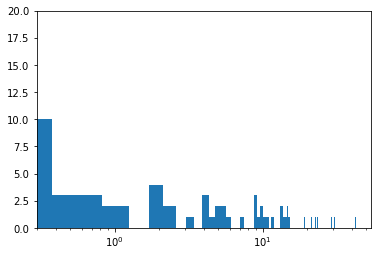

In [17]:
plt.hist(diff,bins=100)
plt.xscale('log')
plt.ylim(0,20)

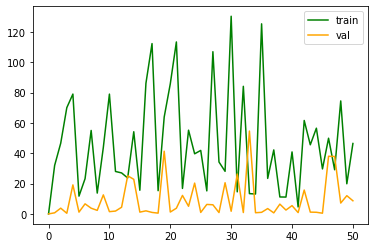

In [18]:
ep = np.arange(0, nepochs+1)
plt.plot(ep, history_train, label='train', color='green')
plt.plot(ep, history_val, label='val', color='orange')
plt.legend()

tensor([54.2568]) tensor([14.0983], grad_fn=<UnbindBackward0>)
tensor([7.2576]) tensor([7.4838], grad_fn=<UnbindBackward0>)


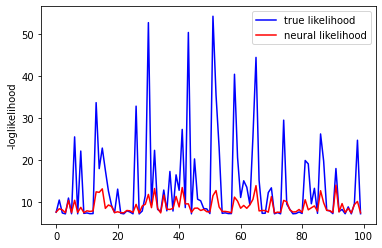

In [19]:
# sns.displot(y_test)
plt.plot(np.sort(y_test.detach().numpy()), color='blue', label='true likelihood')
plt.plot(np.sort(y_pred.detach().numpy()), color='red', label='neural likelihood')
plt.ylabel('-loglikelihood')
plt.legend()
print(max(y_test), max(y_pred))
print(min(y_test), min(y_pred))

In [20]:
np.shape(history_train), np.shape(history_val)

((51,), (51,))

(0.0, 60.0)

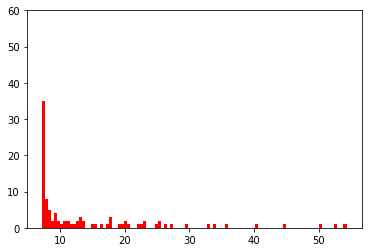

In [21]:
plt.hist(ytest, bins=len(ytest), color='red')
# plt.hist(ypred, bins=len(ypred), color='green')
plt.ylim(0,60)

In [22]:
len(ypred)==len(ytest)

True

In [23]:
len(ypred)

100

In [24]:
pred = map(mlp.forward, X_test)
for res in pred:
    print(type(res), res.item())

<class 'torch.Tensor'> 7.715832710266113
<class 'torch.Tensor'> 8.485013008117676
<class 'torch.Tensor'> 8.220362663269043
<class 'torch.Tensor'> 7.560459136962891
<class 'torch.Tensor'> 10.452359199523926
<class 'torch.Tensor'> 7.569005966186523
<class 'torch.Tensor'> 10.501705169677734
<class 'torch.Tensor'> 7.609738349914551
<class 'torch.Tensor'> 8.81411075592041
<class 'torch.Tensor'> 7.564368724822998
<class 'torch.Tensor'> 7.988768100738525
<class 'torch.Tensor'> 7.853349685668945
<class 'torch.Tensor'> 7.963178634643555
<class 'torch.Tensor'> 12.507362365722656
<class 'torch.Tensor'> 12.383030891418457
<class 'torch.Tensor'> 13.217791557312012
<class 'torch.Tensor'> 8.578206062316895
<class 'torch.Tensor'> 9.37583065032959
<class 'torch.Tensor'> 9.048086166381836
<class 'torch.Tensor'> 7.558465003967285
<class 'torch.Tensor'> 7.764596939086914
<class 'torch.Tensor'> 7.560983180999756
<class 'torch.Tensor'> 7.527746200561523
<class 'torch.Tensor'> 8.08034610748291
<class 'torch.